### 1. Business Understanding

JCPenney is a North American department store that was founded in the year 1902 at Kemmerer Wyoming by James Cash Penney. It's headquaters is at Plano in Texas where it is registered as J.C. Penney Corporation, Inc. to trade in goods and services. In goods, JCPenney is a merchant of clothing, foot wears for men, children, women (including plus size), home products such as beddings, bath, toiletories, kitchen wares and windows accessories. Other accessories in the collection of their products include handbags, jewelries and beuaty products. In addition, they are retailers of branded product such as Nike, Levi, Stanford men's tailored clothing etc. They offer services that include styling salon, optical centers, custom decorating etc. To reach its numerous customer base, the organisation has approximately 647 physical stores outlets in America and Puetorico and maintains an appreciable online presence using its e-commerce platform (jcpenney.com, not currently available in the UK) through which it is able to market goods and services. On the average, it is reported that it reached an of approximate of 26 million online view and a staggering 65 million per month during peak holiday season. Owing to this huge online presence and face to face physical contact with customers and clienteles especially during shopping and provision of services such as salon styling, the organisation is therefore required to maintain a business success strategy that entails  customer satisfaction through excellent services, feedback with a view to mitigate intense negative feedback and churn risk. In addition, to maintain a healthy business to cutomer interaction, it is important that the database system void of data corruption to ensure that accurate customer data are used for personalised customer to business interaction, reliable, secure and accurate decision making.
Sequel to the above business understanding, the <b>objective</b> of this research is defined as follows:

1. To identify the spread of the intensity of customer sentiment across United State and Territory
2. To identify weeknesses in the collection and storage of data with a view to mititgate ineffective customer communication and combat the risk of cyber security if neccessary.

**Data to Use:**
1. all columns of reviews.csv data
2. Price and Av_Score columns from products.csv data
3. all columns from jcpenney_reviewers.json
4. all columns of jcpenney_reviewers.json
5. users.csv excluded due to similarities with jcpenney_reviewers.json

### 2. Abstract : How I answered the above questions to create the project

The strategies implemented is to go from data to actionable business solutions so as to align data initiatives with core business objectives
1. identified customers birthday - no increase in the numbers of birthdays celebrated over the period under review
2. identify duplicated user names
3. identified duplicated empty data structures including strings and list in the databases
4. vader model to gerate polarity scores
5. use kmeans algorithm to fine tune model because the dataset is unlabled
6. use hugging face to generate negative and or positive sentiments
7. The use of linear regression was considered as means to establish relationship between average customer score and price of the product. The process was abandoned because there was no dependable correlation between the columns
8. Comparative analysis was made between the alogortihms used and result dataframe was created from the model and the outcome was used to visualize the sentiments of customers across the united states

### 3. Importing libraries and loading data

In [1]:
##### import libraries for numerical calculations, data and datetime processing
import numpy as np
import pandas as pd
import datetime as dt

# imported for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium

#from folium.plugins import FastMarkerCluster
from folium.plugins import MarkerCluster
from folium.plugins import HeatMap
import branca.element as be
import branca.colormap as cm

# for processing text data, build model that generates vader score for intensity of customer ratings
import re 
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer # vader score processing
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from tqdm.notebook import tqdm

# kmeans is used to cross validate vader output and fine tune the vader score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# to build huggy face ai model and make comparison with other librariew
from transformers import pipeline

import warnings
warnings.filterwarnings("ignore")

In [2]:
#### Load Dataframe
csv_reviews_data = pd.read_csv('data/reviews.csv')
csv_products_data = pd.read_csv('data/products.csv')
csv_user_data = pd.read_csv('data/users.csv')

# The 'lines=True' parameter is used here for json's file to mitigate ValueError: Trailing data
json_reviewers_data = pd.read_json('data/jcpenney_reviewers.json', lines = True)
json_products_data = pd.read_json('data/jcpenney_products.json', lines=True)

In [3]:
states_lat_long_df=pd.read_csv('data/states_data.csv')#Added: Latitude and Longitude data from another source
state_code_df = pd.read_csv('data/state_code.csv') # data obtained from online

### 4. Data Understanding and Preparation - 
Explore the data and show you understand its structure and relations, with the aid of appropriate visualisation techniques. Assess the data quality, which insights you would be able to answer from it, and what preparation the data would require. Add new data from another source if required to bring new insights to the data you already have.

##### (i). Handling unclean data
**(a). null and empty strings**

In [4]:
print(f'Data type of list price column: {json_products_data['list_price'].dtypes}')# expected data type = float

Data type of list price column: object


In [5]:
try:
    json_products_data['list_price'].astype(float)
except ValueError as e:
    print(e)

could not convert string to float: ''


In [43]:
try:
    products_df['sale_price'].astype(float)
except ValueError as e:
    print(e)

could not convert string to float: '12.07-60.42'


In [6]:
def count_empty_string(data):
    """
    Helper function to count numbers of rows that contain empty strings in a column
    """
    count = 0
    for i in data:
        if i == '':
            count += 1
    return count

print(count_empty_string(json_products_data['list_price']))

2166


In [7]:
# Focus is on the price column because SKU and Description are not relevant to this research
csv_products_data.isna().sum()

Uniq_id           0
SKU              67
Name              0
Description     543
Price          2166
Av_Score          0
dtype: int64

observation:
Numbers of empty string in json_products_data['list_price'] = 2166 while numbers of null values in csv_products_data = 2166 (equal amount). 

In [8]:
# They also have equal numbers of rows.
csv_products_data.shape

(7982, 6)

In [9]:
 json_products_data.shape

(7982, 15)

In [10]:
# To ascertain if the index number where json_products_data contains empty data is the same as where csv_products_data contains null data
# Returns True if all of the 2166 rows has matching index numbers
np.unique(json_products_data[json_products_data['list_price']=='']['list_price'].index == csv_products_data[csv_products_data['Price'].isna()].index)

array([ True])

In [11]:
def handle_unclean(data_1, data_2):
    """The function is designed to fill null values and empty strings in two pandas series concurrently using the mean of each series. It first 
    converted the datatypes of the series into an object datatypes and add each numeric row to a corresponding list. The mean of the column is obtained 
    by dividing the sum of each list by the length of the corresponding series. The program then sets the new value of the current location where the 
    data is an empty string or a null value with the mean of the corresponding series
    """
    list_data_1 = []
    list_data_2 = []
    if data_1.dtypes != data_1.astype('O'): 
        data_1 = data_1.astype(str)      # converts the values of the row into a string so as to use string method e.g i.isnumeric() below
    if data_2.dtypes != data_2.astype('O'):
        data_2 = data_2.astype(str)
    for i,j in zip(data_1,data_2):
        if i.isnumeric():
            list_data_1.append(float(i))
        if j.isnumeric():
            list_data_2.append(float(j))
    for i in range(len(data_1)):
        if (data_1[i]=='') or (data_2[i]==''):
            data_1[i]=str(np.sum(pd.to_numeric(list_data_1, errors='coerce'))/len(data_1))# assign mean value to every row that contain empty string
            data_2[i]=str(np.sum(pd.to_numeric(list_data_2, errors='coerce'))/len(data_2))
        elif(data_1[i]==np.nan) or (data_2[i]==np.nan):
            data_1[i]=str(np.sum(pd.to_numeric(list_data_1, errors='coerce'))/len(data_1))# assign mean value to every row that contain null value
            data_2[i]=str(np.sum(pd.to_numeric(list_data_2, errors='coerce'))/len(data_2))
    return [data_1, data_2]    
json_products_data['list_price'],csv_products_data['Price'] = handle_unclean(json_products_data['list_price'], csv_products_data['Price'])

In [12]:
print(f'Numbers of empty strings: {json_products_data[json_products_data['list_price']=='']['list_price'].shape[0]}') # to ascertain if the empty 
#json_products_data['list_price'].astype(float)                                                                                                                      #strings has been removed

Numbers of empty strings: 0


In [13]:
print(f'Numbers of null value: {csv_products_data['Price'].isna().sum()}') # to ascertain if the null values has been removed
#csv_products_data['Price'].astype(float)

Numbers of null value: 0


In [ ]:
products_df['list_price']=products_df['list_price'].astype(float)

In [44]:
products_df['sale_price']=products_df['sale_price'].str.extract(r'(.{4})', expand=False).astype(float) 

,Uniq_id,Av_Score,list_price,sale_price,average_product_rating,total_number_reviews
0,b6c0b6bea69c722939585baeac73c13d,2.625,41.09,24.1,2.625,8
1,93e5272c51d8cce02597e3ce67b7ad0a,3.000,41.09,24.1,3.000,8
2,013e320f2f2ec0cf5b3ff5418d688528,2.625,41.09,24.1,2.625,8
3,505e6633d81f2cb7400c0cfa0394c427,3.500,41.09,24.1,3.500,8
4,d969a8542122e1331e304b09f81a83f6,3.125,41.09,24.1,3.125,8


**(b). empty lists in column rows**

In [14]:
json_reviewers_data.isna().sum()

Username    0
DOB         0
State       0
Reviewed    0
dtype: int64

In [15]:
json_reviewers_data['Reviewed'][0:4]

0                   [cea76118f6a9110a893de2b7654319c0]
1                   [fa04fe6c0dd5189f54fe600838da43d3]
2                                                   []
3    [f129b1803f447c2b1ce43508fb822810, 3b0c9bc0be6...
Name: Reviewed, dtype: object

In [16]:
# complexity of the Reviewed column
print(f'Reviewed column:\nType :{type(json_reviewers_data['Reviewed'])}\nData Type: {json_reviewers_data['Reviewed'].dtypes}\nRow content:{type(json_reviewers_data['Reviewed'][0])}')

Reviewed column:
Type :<class 'pandas.core.series.Series'>
Data Type: object
Row content:<class 'list'>


In [17]:
rows_with_empty_list=json_reviewers_data[json_reviewers_data['Reviewed'].apply(len) == 0] # we target rows that has a len of 0
print(f'Numbers of rows with empty list: {rows_with_empty_list.shape[0]}')

Numbers of rows with empty list: 971


In [18]:
print(f'Alternative code to find numbers of duplicated rows: {json_reviewers_data['Reviewed'].duplicated(keep=False).sum()}')

Alternative code to find numbers of duplicated rows: 971


In [19]:
percentage_rows_with_empty_list=(rows_with_empty_list.shape[0]/json_reviewers_data.shape[0])*100
print(f'Percentage of rows with empty list: {percentage_rows_with_empty_list}%')

Percentage of rows with empty list: 19.42%


**(c). duplicated data:**

In [20]:
print(f' Numbers of Username duplicated rows: {json_reviewers_data.Username.duplicated(keep=False).sum()}')# This is in contrast to the result when the 
                                                                                                        # duplicated method was called on the complete dataframe

 Numbers of Username duplicated rows: 2


In [21]:
duplicated_username = json_reviewers_data[json_reviewers_data['Username'].duplicated(keep=False)] # Extract dataframe for duplicated username
duplicated_username

,Username,DOB,State,Reviewed
731,dqft3311,28.07.1995,Tennessee,[5f280fb338485cfc30678998a42f0a55]
2619,dqft3311,03.08.1969,New Mexico,[571b86d307f94e9e8d7919b551c6bb52]


In [22]:
#passing the duplicated username from json_reviewers_data to csv_reviews_data to extract username generated by the username
csv_duplicated_in_username = csv_reviews_data[csv_reviews_data['Username']=='dqft3311']
print(f'Volume of data generated by duplicated username in reviews.csv data:\n{csv_duplicated_in_username.shape[0]} Rows\n{csv_duplicated_in_username[:3]}')

Volume of data generated by duplicated username in reviews.csv data:
17 Rows
                               Uniq_id  Username  Score  \
4331  e5bdf53f2374569526c9f4d55afdd88e  dqft3311      0   
6991  5f280fb338485cfc30678998a42f0a55  dqft3311      2   
8142  6c3c7832675727669a52f794cdec743d  dqft3311      0   

                                                 Review  
4331  We wanted something to warm us from below not ...  
6991  This dress is very pretty and flattering to al...  
8142  The shoes run big and fit very loose. I wear a...  


**(d). size of unique_id column**

In [23]:
print(f'Numbers of character per row: {len(csv_reviews_data['Uniq_id'][0])}') # to show the number of characters in each row of Uniq_id

Numbers of character per row: 32


In [24]:
print(f'Total numbers of characters in Unique_id Columns: {json_products_data['uniq_id'].shape[0] * len(json_products_data['uniq_id'][0])}')

Total numbers of characters in Unique_id Columns: 255424


In [25]:
# visual appraisal of the size of column and the multiplier effect on other dependent columns in the storage
json_products_data[['uniq_id','Bought With']][:3]

,uniq_id,Bought With
0,b6c0b6bea69c722939585baeac73c13d,"[898e42fe937a33e8ce5e900ca7a4d924, 8c02c262567..."
1,93e5272c51d8cce02597e3ce67b7ad0a,"[bc9ab3406dcaa84a123b9da862e6367d, 18eb69e8fc2..."
2,013e320f2f2ec0cf5b3ff5418d688528,"[3ce70f519a9cfdd85cdbdecd358e5347, b0295c96d2b..."


In [26]:
#visual appraisal of the size of column and the multiplier effect on storage
json_products_data['Bought With'][0]

['898e42fe937a33e8ce5e900ca7a4d924',
 '8c02c262567a2267cd207e35637feb1c',
 'b62dd54545cdc1a05d8aaa2d25aed996',
 '0da4c2dcc8cfa0e71200883b00d22b30',
 '90c46b841e2eeece992c57071387899c']

In [27]:
#visual appraisal of the size of column and the multiplier effect of the column on storage
json_reviewers_data['Reviewed'][7]

['76242d553d8bd2b004eab36da5853016',
 '918493871af32c4ab1ca6aaa530501df',
 'f991a21d9058a37c30567a880dfd3f7e']

### 2. Engineering Features

In [28]:
# Creating new dataframe from result obtained from handling unclean data
products_df=pd.merge(csv_products_data[['Uniq_id','Av_Score']].reset_index(),
         json_products_data[['list_price','sale_price','average_product_rating','total_number_reviews']].reset_index()).drop(columns='index')
products_df.head(2)

,Uniq_id,Av_Score,list_price,sale_price,average_product_rating,total_number_reviews
0,b6c0b6bea69c722939585baeac73c13d,2.625,41.09,24.16,2.625,8
1,93e5272c51d8cce02597e3ce67b7ad0a,3.000,41.09,24.16,3.000,8


In [29]:
# considering that the duplicated  username has a negative multiplier effect, we drop it from both the json_reviewers_data and csv_reviews_data

In [30]:
# Delete username == dqft3311 from jcpenneys_reviewers.json data and save dataframe as reviewers dataframe
reviewers_df = json_reviewers_data.drop(json_reviewers_data[json_reviewers_data['Username'] == 'dqft3311'].index)
# delete Reviewed column from dataframe
reviewers_df.drop(columns=['Reviewed'], inplace=True)

# Delete username == dqft3311 from reviews.csv data and save dataframe as reviews dataframe
reviews_df=csv_reviews_data.drop(csv_reviews_data[csv_reviews_data['Username'] == 'dqft3311'].index)

Detailed research into the dataset indicates that the reveiwers_df is similar to csv_user_data. A quick example is shown by the following two line of codes. As a result, we exclude the csv_use_data to avoid repetition of data.

In [31]:
reviewers_df.head(2)

,Username,DOB,State
0,bkpn1412,31.07.1983,Oregon
1,gqjs4414,27.07.1998,Massachusetts


In [32]:
csv_user_data.iloc[0:2]

,Username,DOB,State
0,bkpn1412,31.07.1983,Oregon
1,gqjs4414,27.07.1998,Massachusetts


In [33]:
# To create a state column in the review_df by matching the usernames in the reviewers_df column
# This is a slow method. The map() function provides a faster approach but the following lines of code demonstrate the use of the zip() function
# map() will be used to map latitude and longitudes to the state columns
state_review_list = []
for u in reviews_df['Username']:
    for x,y in zip(reviewers_df['Username'],reviewers_df['State']):
        if u == x:      #if the usernames in both coloumns are the same ..
            state_review_list.append(y)
reviews_df['State']=state_review_list 
reviews_df.head(3)

,Uniq_id,Username,Score,Review,State
0,b6c0b6bea69c722939585baeac73c13d,fsdv4141,2,You never have to worry about the fit...Alfred...,American Samoa
1,b6c0b6bea69c722939585baeac73c13d,krpz1113,1,Good quality fabric. Perfect fit. Washed very ...,Virginia
2,b6c0b6bea69c722939585baeac73c13d,mbmg3241,2,I do not normally wear pants or capris that ha...,Northern Mariana Islands


**(d). observation:**

According to the construct of json_reviewers_data, each Username is allowed to make multiple reviews hence, the Reviewed column is designed to contain a list of as many unique_ids of items that are reviewed by the user. However, because each Username represent a distinct living individual, it becomes questionable when duplicated Username exists in a database. Although from our findings above, only one Username(dqft3311) is found to be duplicated with two entries at index 731 and 2619 which show different DOBs originating from Tenessee and New Mexico. The multiplier effect of this is that when the Username is passed on to csv_reviews_data, it revealed 17 different entries by the same Username but at this time it is not possible to tell if the entry was made by the user from Tennessee or New Mexico. Such duplication has the tendency to lead to flawed Analytics, defective data integrity, operational inefficiency, faulty decision-making and a precusor to cyber vulnerablity.
The length of the Uniq_id column and the repeated mode of storage is a source of conern.Findings from the precedding programs revealed that each row of the uniq_id contain 32 character string, as the number of rows equals to 7982  the total numbers of string characters contained is equal to twenty five million and five thousand and four hundred and twenty four (255424) characters. This suggests that if each row is reduced by 50%, the organisation can save 50% on storage cost, and improve human readability, speed of processing and mitigate the disadvantage of the multiplier effect when the volume of the data increases. 32 characters of Uniq_id that serves the purpose of only identifying a unique product appears to be too long and has proven to require significantly more storage space in the primary table and foreign table.
While long unique IDs, such as Universally Unique Identifier(UUIDs), offer advantages in distributed systems for global uniqueness without centralized coordination, jcpenney is currently recognised as an american store hence the use of such long Unique_id come at a cost of local database performance, storage efficiency, increased overhead, more difficult technical requirements to debug and added complexities of human usability heurisritics. 


**(e).Data to delete:**

(i). <i/>The Reviewed column of the jcpenney_reviewers.json data.</i>

**Justification to delete:**

   * a. It contains 971 rows of empty list which is a corrupted data
   * b. Deleting the column instead of the rows with empty list will preserve all entries in Username column  which is most relevant to this project
   * c. The information contained in the Reviewed column is still available in the reviews.csv in a different format. 

(ii). <i/>Contents of the Username dqft3311</i>

 **Justification to delete:**
* The username is duplicated. Deleting it will ensure data integrity, improve performance of the model, enhance storage capacity and help to mitigate threat of cyber security in the database as a whole

**(iii). <i/>Unique Id</i>**

Justification: The length of the column is predicted to slow down data process during nltk data processing and values of the rows has no direct bearing to customer sentiments

**(iii). <i/>SKU</i>**

Justification: Is predicted to have similar underlying pattern with unique id and not relevant to customers sentiments

**(iii). <i/>name_title</i>**

Justification: Not relevant to model

Others include product_url', 'product_image_urls', 'brand','Bought With' - are not relevant to customers sentiments

**features to use:**
* reviews_df
* reviewers_df
* products_df

### 3. Visualization of raw data
**(a). Total sum of customer rating per state**

In [34]:
score_per_state_df=reviews_df.groupby(['State'], as_index=False)['Score'].sum()

In [35]:
score_per_state_df=pd.concat([score_per_state_df,state_code_df['Code']],axis=1)

In [36]:
score_per_state_df.columns

Index(['State', 'Score', 'Code'], dtype='object')

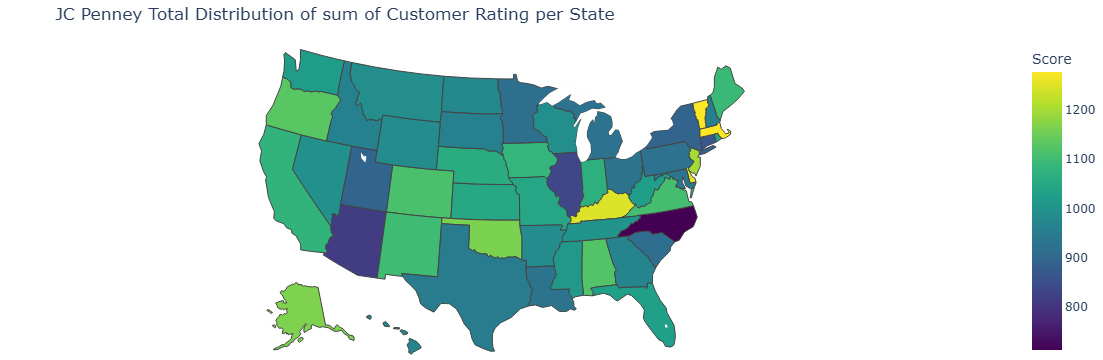

In [84]:
fig = px.choropleth(
    score_per_state_df,
    locations='Code',        
    color='Score',   
    locationmode="USA-states",     
    scope="usa",                   
    color_continuous_scale="Viridis", 
    hover_name='Score',      
    title='JC Penney Distribution of sum of Customer Sentiments per State'
)

fig.update_layout(
    margin={"r":0.2,"t":40,"l":0.5,"b":0},
    coloraxis_showscale=True
)
fig.show()

**(b). Correlation analysis of numeric values**

To ascertain if a relationship exists between the average customer rating score and the list and sale price

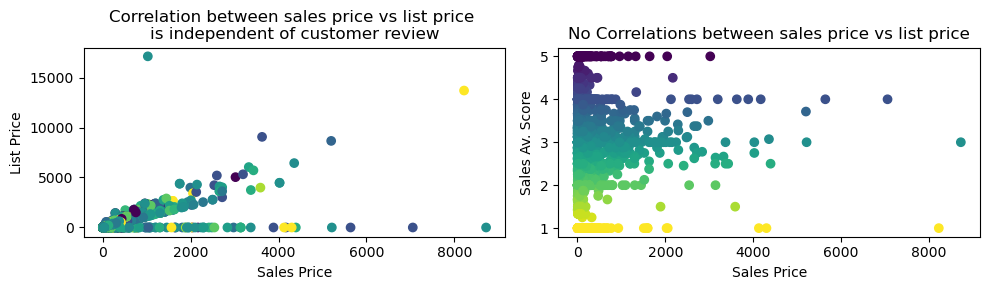

In [87]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 3))
ax1.scatter(products_df['sale_price'], products_df['list_price'], c=products_df['Av_Score'], cmap='viridis_r')
ax1.set_xlabel('Sales Price')
ax1.set_ylabel('List Price')
ax1.set_title('Correlation between sales price vs list price \nis independent of customer review')
ax2.scatter(products_df['sale_price'], products_df['Av_Score'], c=products_df['Av_Score'], cmap='viridis_r')
ax2.set_xlabel('Sales Price')
ax2.set_ylabel('Sales Av. Score')
ax2.set_title('No Correlations between sales price vs list price')
plt.tight_layout()
plt.show()

**(c). Customer birthday analysis**

In [58]:
print(f'Head count of users birthday: {reviewers_df.shape[0]}')
print(f'Total number of users with share birthday with other users: {reviewers_df['DOB'].astype(str).duplicated(keep=False).sum()}')
print(f'Total number of birthday celebrations in a year: {len(reviewers_df['DOB'].unique())}')

Head count of users birthday: 4998
Total number of users with share birthday with other users: 4998
Total number of birthday celebrations in a year: 52


In [59]:
reviewers_df['DOB'].dtypes

dtype('O')

In [60]:
# Converts date to date time to enable visualisation of birthday over a period of time.
reviewers_df['DOB'] = pd.to_datetime(reviewers_df['DOB'])

In [66]:
def extract_date_data(data, d):
    '''
    Helper function to extract dataframes that corresponds to each birthday and save in list
    data = dataframe
    d = target column e.g date column
    '''
    unique_date_list = []
    unique_date_dict = {} 
    count = 0
    for i in data[d].unique():
        unique_date_list.append(data[data[d] == i]) # extract dataframe and add to the last index of the list
        unique_date_dict[i] = len(unique_date_list[count])
        count += 1
    return[unique_date_list, unique_date_dict]

In [67]:
date_data = extract_date_data(reviewers_df, 'DOB') # reviewers dataframe and the data of birth column to the helper function

In [72]:
date_data[1].values()

dict_values([99, 111, 99, 98, 80, 95, 106, 101, 91, 97, 104, 99, 90, 99, 93, 94, 96, 94, 100, 83, 103, 106, 97, 103, 107, 79, 107, 98, 112, 106, 101, 102, 90, 106, 81, 100, 81, 85, 90, 79, 80, 91, 87, 93, 94, 106, 96, 86, 102, 104, 101, 96])

In [73]:
birthdays_df = pd.DataFrame(date_data[1].values(),date_data[1].keys()).reset_index().rename(columns={'index':'Customers DOB', 0:'Numbers Celebrating'})
birthdays_df.head(1)

,Customers DOB,Numbers Celebrating
0,1983-07-31,99


In [75]:
birthdays_df.dtypes

Customers DOB          datetime64[ns]
Numbers Celebrating             int64
dtype: object

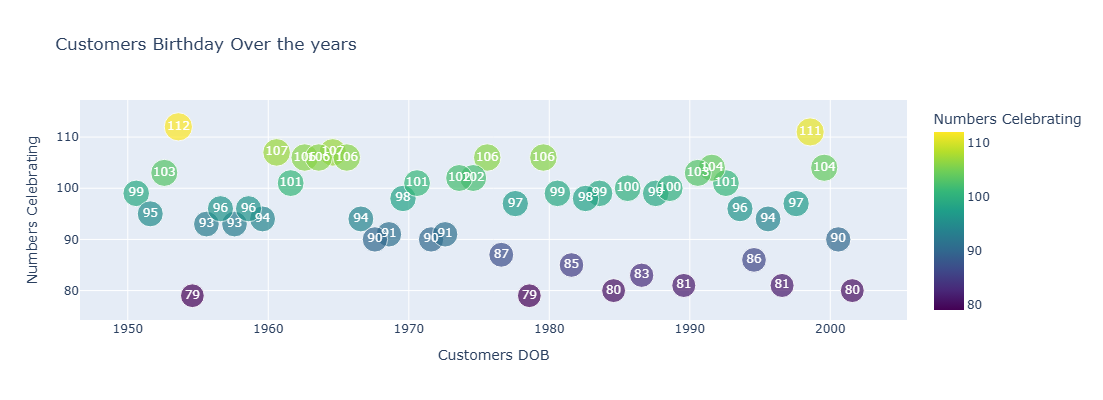

In [74]:
fig= px.scatter(birthdays_df, x='Customers DOB', y='Numbers Celebrating', color='Numbers Celebrating', 
                size='Numbers Celebrating',text='Numbers Celebrating', title='Customers Birthday Over the years',color_continuous_scale=px.colors.sequential.Viridis)
fig.update_traces(textfont_color='#FFF')
fig.update_layout(
    width=1100, # width in pixels
    height=400  # height in pixels
)
fig.show()

**(d). analysis of frequency of customer sentiments**

In [96]:
frequency_sentiments = pd.DataFrame(reviews_df['Score'].value_counts()).reset_index()
frequency_sentiments['Score']=frequency_sentiments['Score'].astype(str)
frequency_sentiments.dtypes

Score    object
count     int64
dtype: object

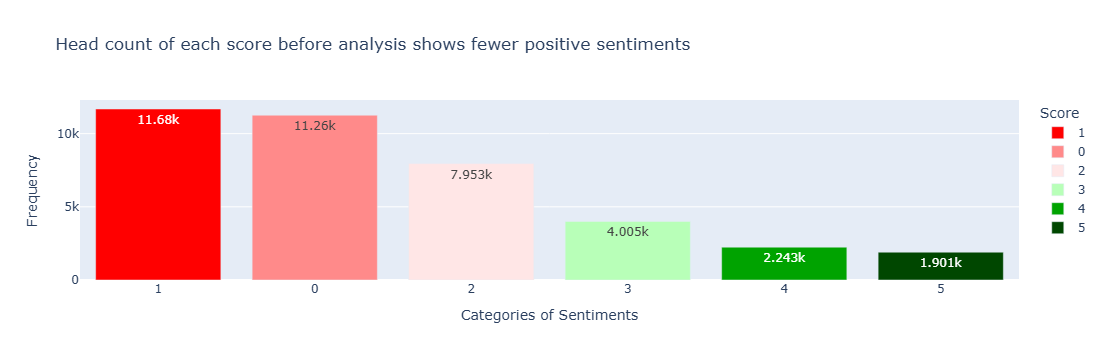

In [99]:
colors_list = ['#FF0000','#FF8A8A','#FFE6E6','#B8FFB8','#00A300','#004700']
fig = px.bar(frequency_sentiments, y='count', x='Score', text_auto='.4s',color='Score',color_discrete_sequence=colors_list,
             title="Head count of each score before analysis shows fewer positive sentiments")
fig.update_layout(
    xaxis_title="Categories of Sentiments",
    yaxis_title="Frequency"
)
fig.show()

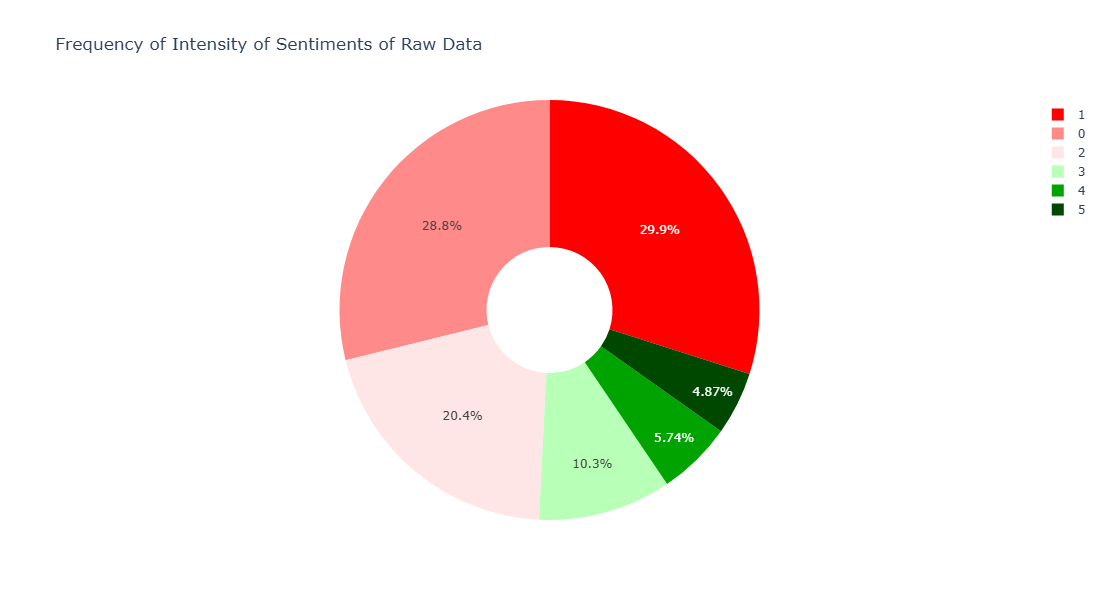

In [101]:
colors_list = ['#FF0000','#FF8A8A','#FFE6E6','#B8FFB8','#00A300','#004700']
fig = px.pie(values=frequency_sentiments['count'], names=frequency_sentiments['Score'], color_discrete_sequence=colors_list, hole=.3, title='Frequency of Intensity of Sentiments of Raw Data')
fig.update_layout(autosize=False, width=800,height=600)
fig.show()

####  3. **Data modeling (optional)** - Would modeling be required for the insights you have considered? Use appropriate techniques, if so.
**(i). Linear Regression model to show relationship between scores and price**

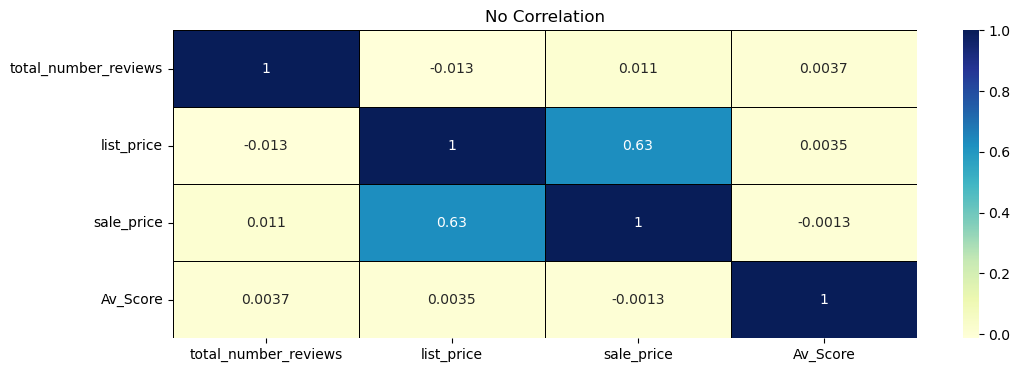

In [103]:
plt.figure(figsize=(12, 4))
sns.heatmap(products_df[['total_number_reviews','list_price','sale_price','Av_Score']].corr(), annot=True, linewidths=.5,cmap="YlGnBu", linecolor='black')
plt.title('No Correlation')
plt.show()

**(ii). Vader**

focus on the reviews_df['Review']

In [104]:
vader_sent_analyzer = SentimentIntensityAnalyzer() # initialize vader sentiments analyser for use to determine the intensity of the 
                                                   # negativity, neutrality and positivity of customer sentiments on the Review column
vader_sent_analyzer # to ascertain that vader is initialize in the progra

In [105]:
porter = PorterStemmer() # To reduces words to their base or root form by removing prefixes and suffixes
lemma = WordNetLemmatizer()

def processing_data(data):
    """
    This function will perform the following functions 1. str.lower() 2. remove all special characters 3. word tokenize, 4. stemmer, 5. lemmatize. It is
    designed to be passed on to the reviews_df['Review'] column
    """
    holding_list = []
    for i in data:
        lower_word_tokenized = str(word_tokenize(i.lower()))
        remove_special_char = re.sub(r'[^\w\s]',"",lower_word_tokenized)
        if not remove_special_char in stopwords.words('english'): # remove stop words
            stem_data = (porter.stem(remove_special_char)) #apply stemer to data
            holding_list.append(lemma.lemmatize(stem_data)) # append lematizer to holding list
    return holding_list

In [106]:
# Use the processing_data() function above to clean the Review column and create a new column with it
reviews_df['Cleaned Review'] = processing_data(reviews_df['Review'])
reviews_df['Cleaned Review'].dtypes

dtype('O')

In [107]:
# Vader helper function 
def get_polarity_scores(data, column):
    """
    run sentiment analyzer on all the rows text of the Cleaned Review data and return a pandas dataframe. The output is a dataframe 
    that contains the polority scores of the Cleaned Review column.
    """
    data_structure = []
    for row in data[column]:
        data_structure.append(vader_sent_analyzer.polarity_scores(row)) 
    return pd.DataFrame(data_structure) # to return a new dataframe that contain the polarity scores

In [108]:
# run vader sentiment analyser to generate polarity scores to show the intensity
# of customers sentiments
polarity_scores_df = get_polarity_scores(reviews_df,'Cleaned Review') # to save the output dataframe from the function in a variable
polarity_scores_df.head(2)

,neg,neu,pos,compound
0,0.000,0.494,0.506,0.9546
1,0.131,0.264,0.606,0.8408


In [110]:
# Merge polarity_scores_df with reviews_df by creating a dummy index column for use as a common column to both dataframes
score_output_df = pd.merge(polarity_scores_df.reset_index(),reviews_df.reset_index(), on='index')[['Username','State','neg','neu','pos','compound','Score','Cleaned Review']]
score_output_df.head(2)
# an alternative line of code to use to merge the dataframes is pd.concat([reviews_df,polarity_scores_df],axis=1) however this is proned to generating
# Null values in its output thereby may require additional lines of codes which is not desirable

,Username,State,neg,neu,pos,compound,Score,Cleaned Review
0,fsdv4141,American Samoa,0.000,0.494,0.506,0.9546,2,you never have to worry about the fit alfred ...
1,krpz1113,Virginia,0.131,0.264,0.606,0.8408,1,good quality fabric perfect fit washed very ...


In [115]:
def vader_sentiment_helper(data):
    vader_list = []
    for val in data:
        if val >= 0.05:
            vader_list.append('Positive')
        elif -0.05 < val < 0.05:
            vader_list.append('Neutral')
        elif val <= -0.05:
            vader_list.append('Negative')
    return vader_list
score_output_df['vader_sentiments'] = vader_sentiment_helper(score_output_df['compound'])

In [130]:
score_output_df[score_output_df['Score']==0].head(2)

,Username,State,neg,neu,pos,compound,Score,Cleaned Review,vader_sentiments
3,zeqg1222,Connecticut,0.0,0.553,0.447,0.9292,0,i love these capris they fit true to size and...,Positive
10,ixlo1324,Guam,0.0,0.733,0.267,0.9492,0,i do not normally wear pants or capris that ha...,Positive


In [122]:
score_output_df[score_output_df['Score']==0]['Cleaned Review'][24]# zero customer score but positve sentiment and positive vader classification

'you never have to worry about the fit  alfred dunner clothing sizes are true to size and fits perfectly  great value for the money '

In [129]:
score_output_df[score_output_df['vader_sentiments']=='Negative'].head(2)

,Username,State,neg,neu,pos,compound,Score,Cleaned Review,vader_sentiments
5,aajh3423,Vermont,0.135,0.865,0.0,-0.4973,2,i did not like the fabric it is 100 polyeste...,Negative
13,tyfr4414,Ohio,0.135,0.865,0.0,-0.4973,4,i did not like the fabric it is 100 polyeste...,Negative


In [128]:
score_output_df[score_output_df['vader_sentiments']=='Negative']['Cleaned Review'][38973] # Negative vader score but positive customer sentiments

'love this vacuum  it took literally 5 minutes to assemble and once i started to use it  my carpets never looked cleaner  easy to empty  the pet hair tools work better than expected '

In [137]:
score_output_df.iloc[38973]

Username                                                     pwyr3321
State                                        Northern Mariana Islands
neg                                                             0.111
neu                                                             0.786
pos                                                             0.103
compound                                                      -0.1147
Score                                                               1
Cleaned Review      love this vacuum  it took literally 5 minutes ...
vader_sentiments                                             Negative
Name: 38973, dtype: object

In [ ]:
# Fine tune model kmeans - non label classification

In [138]:
score_output_df

,Username,State,neg,neu,pos,compound,Score,Cleaned Review,vader_sentiments
0,fsdv4141,American Samoa,0.000,0.494,0.506,0.9546,2,you never have to worry about the fit alfred ...,Positive
1,krpz1113,Virginia,0.131,0.264,0.606,0.8408,1,good quality fabric perfect fit washed very ...,Positive
2,mbmg3241,Northern Mariana Islands,0.000,0.733,0.267,0.9492,2,i do not normally wear pants or capris that ha...,Positive
3,zeqg1222,Connecticut,0.000,0.553,0.447,0.9292,0,i love these capris they fit true to size and...,Positive
4,nvfn3212,Oklahoma,0.000,0.736,0.264,0.5563,3,this product is very comfortable and the fabri...,Positive
...,...,...,...,...,...,...,...,...,...
39024,lfvh2433,American Samoa,0.000,0.703,0.297,0.8225,2,i recently purchased this vac and wow what a ...,Positive
39025,hcot3123,Ohio,0.000,0.642,0.358,0.9576,1,this is a very good productpicks up everything...,Positive
39026,zksc1322,Ohio,0.000,0.761,0.239,0.7650,0,this is just what i was looking for in a new v...,Positive
39027,uvxg2432,Alaska,0.000,0.798,0.202,0.8221,0,i found that this vacuum works very well it r...,Positive


In [140]:
le = LabelEncoder()
score_output_df['encoded_username']=le.fit_transform(score_output_df['Username'])
score_output_df['encoded_state']=le.fit_transform(score_output_df['State'])
score_output_df['encoded_review']=le.fit_transform(score_output_df['Cleaned Review'])
score_output_df.dtypes

Username             object
State                object
neg                 float64
neu                 float64
pos                 float64
compound            float64
Score                 int64
Cleaned Review       object
vader_sentiments     object
encoded_username      int64
encoded_state         int64
encoded_review        int64
dtype: object

In [142]:
kmeans_data=score_output_df[['encoded_username','encoded_state','Score','encoded_review','compound']]
kmeans_data.head(2)

,encoded_username,encoded_state,Score,encoded_review,compound
0,1093,2,2,29418,0.9546
1,2051,52,1,3049,0.8408


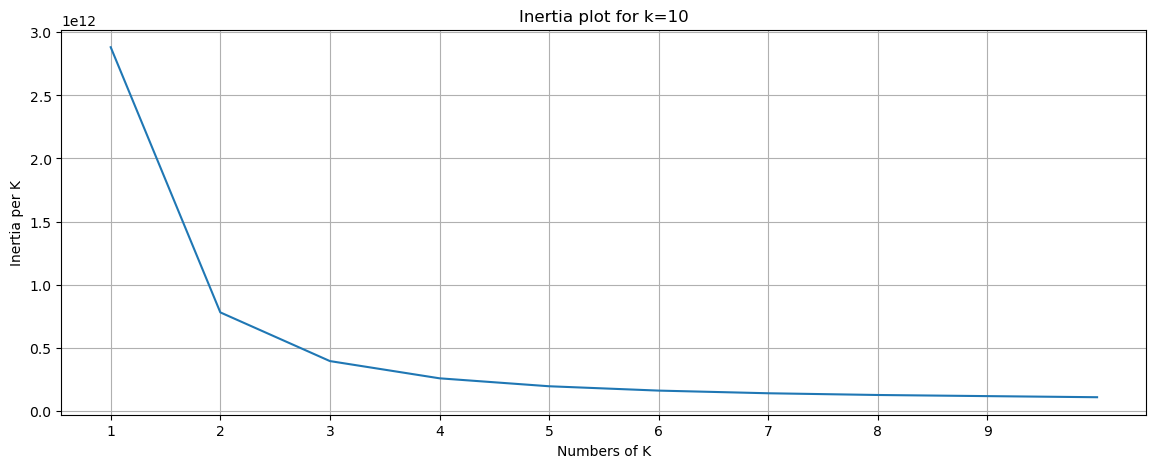

In [147]:
inertia_data = []
for k in np.arange(1,10 + 1):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(kmeans_data)#'neg','neu','pos',,
    inertia_data.append(kmeans.inertia_)

plt.figure(figsize=(14,5))
plt.plot(np.arange(1,10 + 1), inertia_data)
plt.xticks(np.arange(1,10), rotation=0)
plt.xlabel('Numbers of K')
plt.ylabel('Inertia per K')
plt.grid(True)
plt.title('Inertia plot for k=10')
plt.show()

In [154]:
kmeans_3=KMeans(n_clusters=3, n_init=10, random_state=55) #[n_clusters=6 generates classes of 6 different scores[0,1,2]]
kmeans_3.fit(kmeans_data)
labels=kmeans_3.predict(kmeans_data) + 1 # classify data into labels
np.unique(labels)

array([1, 2, 3], dtype=int32)

In [155]:
score_output_df['kmeans_3'] = labels

In [157]:
score_output_df.head()

,Username,State,neg,neu,pos,compound,Score,Cleaned Review,vader_sentiments,encoded_username,encoded_state,encoded_review,kmeans_3
0,fsdv4141,American Samoa,0.000,0.494,0.506,0.9546,2,you never have to worry about the fit alfred ...,Positive,1093,2,29418,2
1,krpz1113,Virginia,0.131,0.264,0.606,0.8408,1,good quality fabric perfect fit washed very ...,Positive,2051,52,3049,1
2,mbmg3241,Northern Mariana Islands,0.000,0.733,0.267,0.9492,2,i do not normally wear pants or capris that ha...,Positive,2304,38,6606,1
3,zeqg1222,Connecticut,0.000,0.553,0.447,0.9292,0,i love these capris they fit true to size and...,Positive,4822,7,9698,3
4,nvfn3212,Oklahoma,0.000,0.736,0.264,0.5563,3,this product is very comfortable and the fabri...,Positive,2630,40,26428,2


In [163]:
result_df=score_output_df[['Username','State','vader_sentiments','Score','kmeans_3','Cleaned Review']]
result_df.head()

,Username,State,vader_sentiments,Score,kmeans_3,Cleaned Review
0,fsdv4141,American Samoa,Positive,2,2,you never have to worry about the fit alfred ...
1,krpz1113,Virginia,Positive,1,1,good quality fabric perfect fit washed very ...
2,mbmg3241,Northern Mariana Islands,Positive,2,1,i do not normally wear pants or capris that ha...
3,zeqg1222,Connecticut,Positive,0,3,i love these capris they fit true to size and...
4,nvfn3212,Oklahoma,Positive,3,2,this product is very comfortable and the fabri...


In [164]:
result_df[result_df['vader_sentiments']=='Negative']

,Username,State,vader_sentiments,Score,kmeans_3,Cleaned Review
5,aajh3423,Vermont,Negative,2,1,i did not like the fabric it is 100 polyeste...
13,tyfr4414,Ohio,Negative,4,1,i did not like the fabric it is 100 polyeste...
21,poql1141,Maine,Negative,1,1,i did not like the fabric it is 100 polyeste...
29,bjja4413,Indiana,Negative,0,1,i did not like the fabric it is 100 polyeste...
37,nqqs2313,North Carolina,Negative,1,1,i did not like the fabric it is 100 polyeste...
...,...,...,...,...,...,...
38973,pwyr3321,Northern Mariana Islands,Negative,1,3,love this vacuum it took literally 5 minutes ...
38981,pbis2431,California,Negative,0,1,2 cats long hair and a long haired german sh...
38989,vwuj3242,American Samoa,Negative,5,1,i like that its light and there are not bags t...
38997,fqdc4333,District of Columbia,Negative,2,1,i like that its light and there are not bags t...


#### 4. **Evaluation and deployment** - How do the insights you obtained help the company, and how can should they be adopted in their business? If modeling techniques have been adopted, are their use scientifically sound and how should they be mantained?